In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('bank-full.csv', sep = ';')
econ_data = pd.read_csv('bank-additional-full.csv', sep = ';')

## Attribute Description

### i) Bank Client Data:
    1 - age (numeric)
    2 - job : type of job (categorical: "admin.","unknown","unemployed","management",
                                        "housemaid","entrepreneur","student", "blue-collar",
                                        "self-employed","retired", "technician","services")
    3 - marital : marital status (categorical: "married","divorced","single"; 
                                         note: "divorced" means divorced or widowed) 
    4 - education (categorical: "unknown","secondary","primary","tertiary") 
    5 - default: has credit in default? (binary: "yes","no") 
    6 - balance: average yearly balance, in euros (numeric) 
    7 - housing: has housing loan? (binary: "yes","no") 
    8 - loan: has personal loan? (binary: "yes","no") 
### ii) Related with the last contact of the current campaign:
    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
    10 - day: last contact day of the month (numeric) 
    11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") 
    12 - duration: last contact duration, in seconds (numeric) 
### iii) Other Attributes:
    13 - campaign: number of contacts performed during the campaign for this client (numeric, includes last contact)
    14 - pdays: number of days that passed by after the client was last contacted from a previous campaign 
               (numeric, -1 means client was not previously contacted)
    15 - previous: number of contacts performed before this campaign and for this client (numeric)
    16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

### iv) Output Variable (desired target):
    17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Project Outline

## a. Campaign Performance Deep Dive Report
    1) How Did the Campaign Go?
        - Overall Performance
        - Quarterly Trended View
        - Macro-Economic Factors
        - Performance by Contact Type and Month
        - Call Duration by Campaign Response
        
    2) Who Responded?
        - Profile Analysis 
            a) Responder vs. Non Responder
            b) Prospect vs. Existing Customer
    

## b. Recommendations
    1) What Could Be Done Right Now?
        - Quick and easy fixes (e.g. Contact Frequency, Contact Period, etc)
    
    2) How Could We Target Better?
        - Rule Based Decisioning Approach
        
        - Machine Learning Approach
            a) Segmentation : To better understand which group of customers are more responsive to the offer
            b) Predictive Model : To Improve targeting customers who are more likely to respond to the offer

## Quick QC of the Dataset

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# Campaign Performance Deep Dive Report
## 1. How did the Campaign go?
    - Overall Performance
    - Quarterly Trended View
    - Macro-Economic Factors
    - Performance by Contact Type and Month
    - Call Duration by Campaign Response
    
### Overall Performance

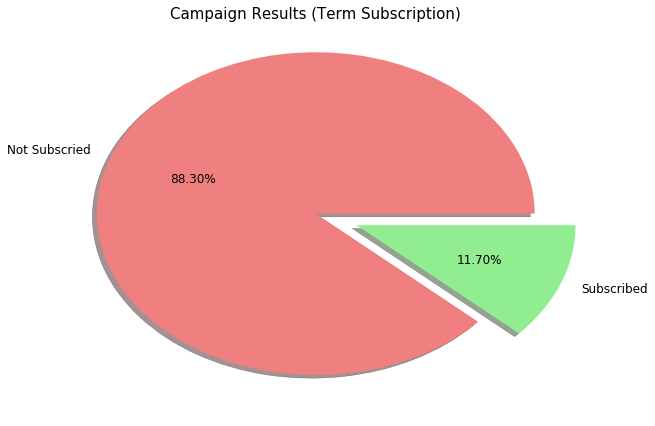

In [187]:
f, ax = plt.subplots(figsize=(8,6))

labels =["Not Subscried", "Subscribed"]

plt.suptitle('Campaign Results (Term Subscription)', fontsize=15)

pie_chart = data["y"].value_counts().plot.pie(explode=[0,0.2], autopct='%1.2f%%', shadow=True, 
                                              colors= ['lightcoral','lightgreen'], 
                                              labels=labels, fontsize=12)
ax.set_ylabel('', fontsize=14, labelpad= 100)

plt.tight_layout()
plt.show()

### QoQ Volume and Response Rate

In [7]:
import more_itertools as mit      
        
def assign_year_mth_qtr(data):
    mth_dict = {'jan' : '01', 'feb' : '02', 'mar' : '03',
                'apr' : '04', 'may' : '05', 'jun' : '06',
                'jul' : '07', 'aug' : '08', 'sep' : '09',
                'oct' : '10', 'nov' : '11', 'dec' : '12'}
    
    qtr_dict = {'jan' : 'Q1', 'feb' : 'Q1', 'mar' : 'Q1',
                'apr' : 'Q2', 'may' : 'Q2', 'jun' : 'Q2',
                'jul' : 'Q3', 'aug' : 'Q3', 'sep' : 'Q3',
                'oct' : 'Q4', 'nov' : 'Q4', 'dec' : 'Q4'}
    
    unique_mth = data['month'].unique()
    year_list = ['2008','2009','2010']
    
    for month in unique_mth:
        iterable = data[data['month'] == month].index.tolist()
        indice_list = [list(group) for group in mit.consecutive_groups(iterable)]
    
    
        for ind in range(len(indice_list)):
            yr_ind = ind + 1 if month in ['jan','feb','mar','apr','sep'] and len(indice_list) == 2 else ind
            data.loc[indice_list[ind],'year'] = year_list[yr_ind]
    data['quarter'] = data['year'] + data['month'].map(qtr_dict)        
    data['month'] = data['month'].map(mth_dict)
    data['date'] = data['year'] + '-' + data['month']
    
    return data

In [8]:
data = assign_year_mth_qtr(data)

In [9]:
resp_quarterly = data[['quarter','y']].groupby(by = ['quarter','y']).size().unstack()
resp_quarterly['total'] = resp_quarterly['no'] + resp_quarterly['yes']
resp_quarterly['resp_rate'] = round(resp_quarterly['yes'] / resp_quarterly['total'],4)

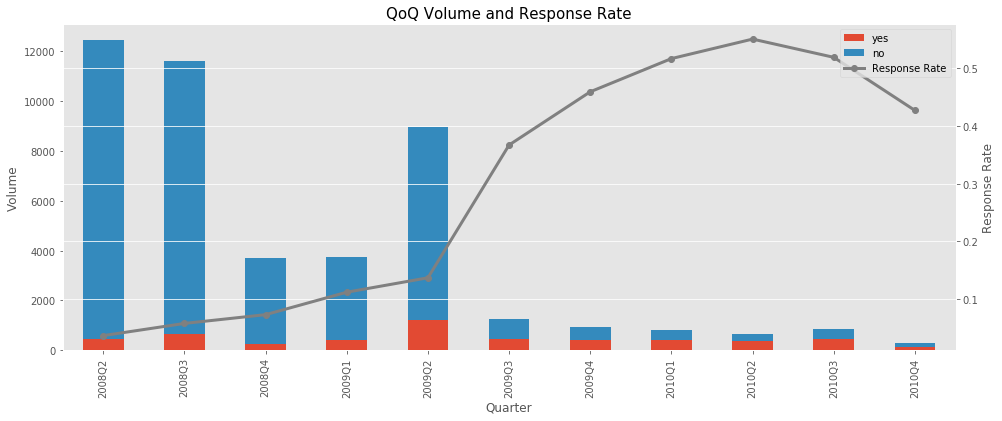

In [138]:
f, ax = plt.subplots(figsize = (16,6))
ax2 = ax.twinx()

bar_plot = resp_quarterly[['yes','no']].plot(kind = 'bar', stacked = True, ax = ax, legend = False)
ln_plot = resp_quarterly.plot(y = 'resp_rate', label = 'Response Rate', secondary_y = True, 
                          ax = ax2, color = 'grey', marker = 'o', lw = 3, legend = False)

plt.title('QoQ Volume and Response Rate', fontsize = 15)

bar_plot.set_xlabel('Quarter')
bar_plot.set_ylabel('Volume')
ln_plot.set_ylabel('Response Rate')

h1, l1 = bar_plot.get_legend_handles_labels()
h2, l2 = ln_plot.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc = 1)

ax.grid(b=None)

plt.show()

### Macro-Economic Factors

In [36]:
econ_metrics_by_mth = assign_year_mth_qtr(econ_data).loc[:,['date','emp.var.rate', 'cons.price.idx', 
                                                  'cons.conf.idx', 'euribor3m', 'nr.employed']].drop_duplicates()

In [37]:
emp_var_rate_by_mth = econ_metrics_by_mth[['date','emp.var.rate']].drop_duplicates().set_index('date')
cons_price_idx_by_mth = econ_metrics_by_mth[['date','cons.price.idx']].drop_duplicates().set_index('date')
cons_conf_idx_by_mth = econ_metrics_by_mth[['date','cons.conf.idx']].drop_duplicates().set_index('date')
num_employed_by_mth = econ_metrics_by_mth[['date','nr.employed']].drop_duplicates().set_index('date')
euribor3m_by_mth = econ_metrics_by_mth[['date','euribor3m']].groupby(by = 'date').mean()

In [38]:
resp_by_mth = data[['date','y']].groupby(by = ['date','y']).size().unstack().reset_index()
resp_by_mth = resp_by_mth.set_index('date')

dates = pd.date_range('05/01/2008', '11/30/2010', freq = 'M')
dates = [str(date).split(' ')[0] for date in dates]
dates = [date.split('-')[0] + '-' + date.split('-')[1] for date in dates]

resp_by_mth = resp_by_mth.reindex(dates)

resp_by_mth['total'] = resp_by_mth[['no','yes']].sum(axis = 1)
resp_by_mth['resp_rate'] = round(resp_by_mth['yes'] / resp_by_mth['total'],4)
resp_by_mth.fillna(0, inplace = True)

In [39]:
resp_econ_tom = resp_by_mth.join([emp_var_rate_by_mth,cons_price_idx_by_mth, cons_conf_idx_by_mth, 
                                  num_employed_by_mth, euribor3m_by_mth], 
                                  how = 'left')
resp_econ_tom = resp_econ_tom.interpolate()

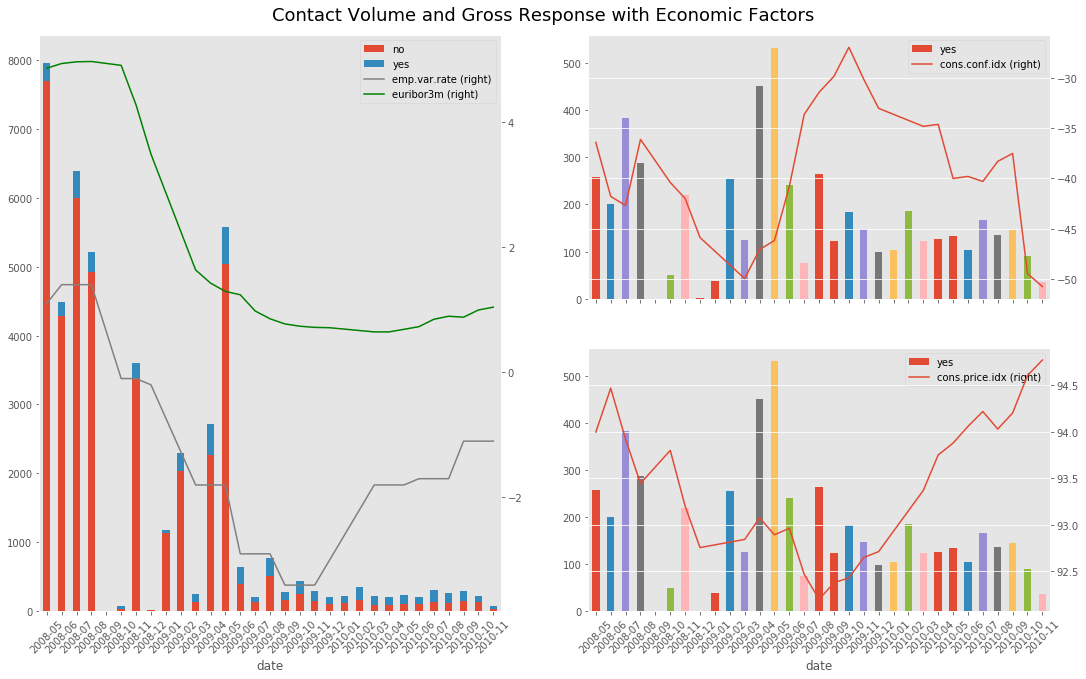

In [40]:
f, ax = plt.subplots(figsize = (16,10))

plt.subplot(121)
resp_econ_tom[['no','yes']].plot(kind = 'bar', stacked = True, ax=plt.gca())
resp_econ_tom.plot(y = ['emp.var.rate'], ax = plt.gca(), secondary_y = True, rot =45, color = 'grey', lw = 1.5)
resp_econ_tom.plot(y = ['euribor3m'], ax = plt.gca(), secondary_y = True, color = 'green', lw = 1.5)

plt.subplot(222)
resp_econ_tom.plot(y = 'yes', kind = 'bar', ax = plt.gca())
resp_econ_tom.plot(y = 'cons.conf.idx', ax = plt.gca(), secondary_y = True,rot =45)

plt.subplot(224)
resp_econ_tom.plot(y = 'yes', kind = 'bar', ax = plt.gca(), rot = 45)
resp_econ_tom.plot(y = 'cons.price.idx', ax = plt.gca(), secondary_y = True, rot =45)

plt.suptitle('Contact Volume and Gross Response with Economic Factors', fontsize = 18)
plt.tight_layout(pad = 4)
plt.show()

### Subscription Rate (%) by Communcation Type and Month

In [11]:
def subscr_rate_by_col(dataframe, colname):
    data = dataframe.copy()
    counts = data.groupby(by = [colname,'y'], as_index=False).size().unstack()
    
    counts['total'] = counts.sum(axis = 1)
    counts['no_perc'] = round(counts['no']/ counts['total'] * 100,2)
    counts['yes_perc'] = round(counts['yes'] / counts['total'] * 100,2)
    
    counts.drop(['no','yes'], axis = 1, inplace = True)
    counts.rename(columns = {'no_perc' : 'no', 'yes_perc' : 'yes'}, inplace = True)
    
    plot_title = 'Subscription Rate(%) by {}'.format(colname.upper())
    
    plot = counts[['yes','no']].plot(kind= 'bar', stacked = True, title = plot_title, ax=plt.gca(), fontsize = 15)
    plt.xlabel(colname.upper(), fontsize=15, labelpad = 15)
    plt.legend(loc = 'upper right')
    
    return plot

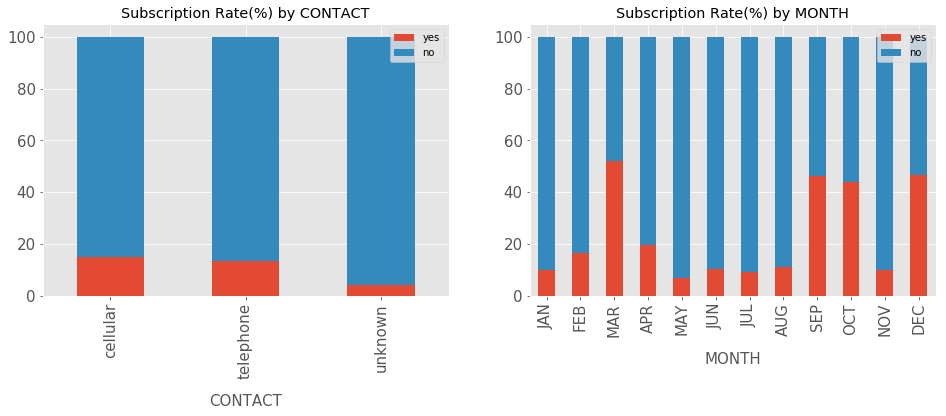

In [12]:
f, ax = plt.subplots(figsize = (16,5))
plt.subplot(121)
contact_plot = subscr_rate_by_col(data, 'contact')

plt.subplot(122)
resp_plot = subscr_rate_by_col(data, 'month')
resp_plot.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])

plt.show()

### Call Duration by Campaign Response

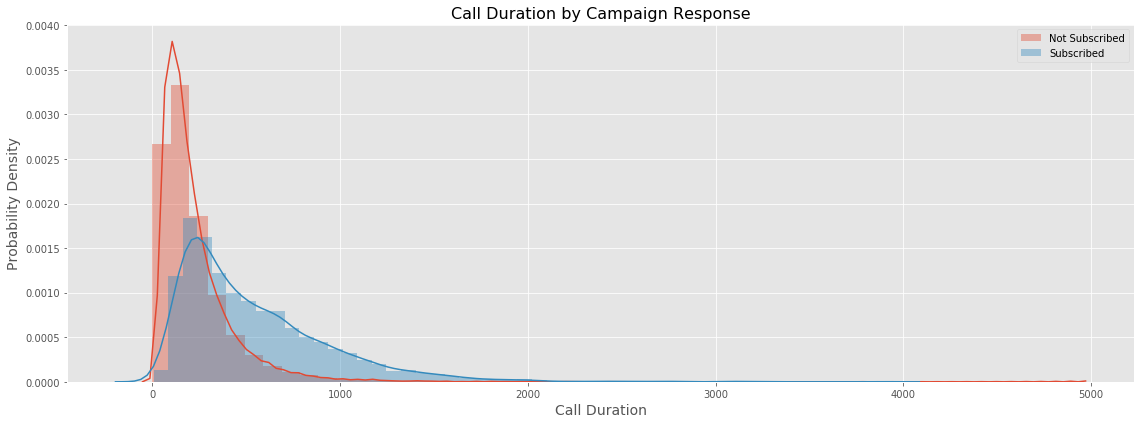

In [13]:
f, ax = plt.subplots(figsize = (16,6))

no_plot = sns.distplot(data.loc[data['y'] == 'no', 'duration'], label = 'Not Subscribed')
yes_plot = sns.distplot(data.loc[data['y'] == 'yes', 'duration'], label = 'Subscribed')

ax.legend(['Not Subscribed', 'Subscribed'], loc = 1)
ax.set_ylabel('Probability Density', fontsize = 14)
ax.set_xlabel('Call Duration', fontsize = 14)
ax.set_title('Call Duration by Campaign Response', fontsize = 16)

plt.tight_layout()

plt.show()

## 2. Who Responded?
    - Profile Analysis 
        a) Responder vs. Non Responder
        b) Prospect vs. Existing Customer
### Customer Profiles (Responder vs. Non-Responder     |      Prospect vs. Existing Customer)

1. Average Age
2. Marital Status
3. Education
3. Occuapation
4. Mortgage
5. Default
6. Other Loan
7. Average Balance

In [47]:
responder = data[data['y'] == 'yes']
non_responder = data[data['y'] == 'no']

prospect = responder[responder['previous'] == 0]
customer = responder[responder['previous'] != 0]

In [174]:
def profile_generator(data):
    sample_size = len(data)
    volume = pd.Series(sample_size, index = ['Volume'])
    avg_age = pd.Series(round(data.age.mean(),1), index = ['Average Age'])
    marital_status = round(data.groupby('marital').size() / sample_size * 100, 2).apply(lambda x : str(x)+'%')
    marital_status = pd.Series(marital_status, name = 'Marital Status')
    edu_level = round(data.groupby('education').size() / sample_size * 100, 2).apply(lambda x : str(x)+'%')
    occupation = round(data.groupby('job').size() / sample_size * 100, 2).apply(lambda x : str(x)+'%')
    mortgage = pd.Series(str(round(data.groupby('housing').size()['yes'] / sample_size * 100, 2)) + '%', index = ['Mortgage'])
    default = pd.Series(str(round(data.groupby('default').size()['yes'] / sample_size * 100, 2)) + '%', index = ['Default'])
    other_loan = pd.Series(str(round(data.groupby('loan').size()['yes'] / sample_size * 100, 2)) + '%', index = ['Other Loan'])
    avg_balance = pd.Series('$' + str(round(data.balance.mean(),2)), index = ['Average Balance ($)'])
    
    profile_comp = [volume, avg_age, marital_status, edu_level, occupation, mortgage, default, other_loan, avg_balance]
    
    profile = pd.concat(profile_comp, axis = 0)
    profile = profile[profile.index != 'unknown']
    profile = profile.tolist()
    
    index = [('', 'Volume'), ('', 'Average Age'), 
             ('Marital Status', 'Divorced'), ('Marital Status', 'Married'), ('Marital Status', 'Single'),
             ('Education', 'Primary'), ('Education', 'Secondary'), ('Education', 'Tertiary'),
             ('Occupation', 'Admin.'), ('Occupation', 'Blue Collar'), ('Occupation', 'Entrepreneur'), 
             ('Occupation', 'Housemaid'), ('Occupation', 'management'), ('Occupation', 'Retired'),
             ('Occupation', 'self-employed'), ('Occupation', 'services'), ('Occupation', 'student'),
             ('Occupation', 'technician'), ('Occupation', 'unemployed'),
             ('', 'Mortgage'), ('', 'Default'), ('', 'Other Loan'), ('', 'Average Balance ($)')
            ]
    
    index = pd.MultiIndex.from_tuples(index)
    
    return pd.Series(profile, index = index)

In [175]:
overall_profile = profile_generator(data)

responder_profile, non_responder_profile = profile_generator(responder), profile_generator(non_responder)
prospect_profile, customer_profile = profile_generator(prospect), profile_generator(customer)

resp_vs_non_resp = pd.concat([responder_profile, non_responder_profile, overall_profile], axis = 1).\
                                rename(columns = {0 : 'Responder', 1 : 'Non Responder', 2 : 'Overall'})
prosp_vs_cust = pd.concat([prospect_profile, customer_profile, responder_profile], axis = 1).\
                                rename(columns = {0 : 'Prospect', 1 : 'Customer', 2 : 'Responder Overall'})

In [176]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
        
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

display_side_by_side(resp_vs_non_resp, prosp_vs_cust)

Responder 
 Non Responder 
 Overall 
 
 
 
 
 
 Volume 
 5289 
 39922 
 45211 
 
 
 Average Age 
 41.7 
 40.8 
 40.9 
 
 
 Marital Status 
 Divorced 
 11.76% 
 11.48% 
 11.52% 
 
 
 Married 
 52.09% 
 61.27% 
 60.19% 
 
 
 Single 
 36.15% 
 27.25% 
 28.29% 
 
 
 Education 
 Primary 
 11.17% 
 15.68% 
 15.15% 
 
 
 Secondary 
 46.32% 
 51.98% 
 51.32% 
 
 
 Tertiary 
 37.74% 
 28.32% 
 29.42% 
 
 
 Occupation 
 Admin. 
 11.93% 
 11.37% 
 11.44% 
 
 
 Blue Collar 
 13.39% 
 22.6% 
 21.53% 
 
 
 Entrepreneur 
 2.33% 
 3.42% 
 3.29% 
 
 
 Housemaid 
 2.06% 
 2.83% 
 2.74% 
 
 
 management 
 24.6% 
 20.43% 
 20.92% 
 
 
 Retired 
 9.76% 
 4.38% 
 5.01% 
 
 
 self-employed 
 3.54% 
 3.49% 
 3.49% 
 
 
 services 
 6.98% 
 9.48% 
 9.19% 
 
 
 student 
 5.09% 
 1.68% 
 2.07% 
 
 
 technician 
 15.88% 
 16.93% 
 16.8% 
 
 
 unemployed 
 3.82% 
 2.76% 
 2.88% 
 
 
 
 Mortgage 
 36.59% 
 58.1% 
 55.58% 
 
 
 Default 
 0.98% 
 1.91% 
 1.8% 
 
 
 Other Loan 
 9.15% 
 16.93% 
 16.02% 
 
 
 Average Balance ($) 
 $1804.27 
 $1303.71 
 $1362.27 
 
 
 
 
 
 
 
 Prospect 
 Customer 
 Responder Overall 
 
 
 
 
 
 Volume 
 3384 
 1905 
 5289 
 
 
 Average Age 
 41.2 
 42.5 
 41.7 
 
 
 Marital Status 
 Divorced 
 12.94% 
 9.66% 
 11.76% 
 
 
 Married 
 50.38% 
 55.12% 
 52.09% 
 
 
 Single 
 36.67% 
 35.22% 
 36.15% 
 
 
 Education 
 Primary 
 12.35% 
 9.08% 
 11.17% 
 
 
 Secondary 
 47.13% 
 44.88% 
 46.32% 
 
 
 Tertiary 
 35.9% 
 41.0% 
 37.74% 
 
 
 Occupation 
 Admin. 
 11.29% 
 13.07% 
 11.93% 
 
 
 Blue Collar 
 15.48% 
 9.66% 
 13.39% 
 
 
 Entrepreneur 
 2.84% 
 1.42% 
 2.33% 
 
 
 Housemaid 
 2.22% 
 1.78% 
 2.06% 
 
 
 management 
 23.02% 
 27.4% 
 24.6% 
 
 
 Retired 
 9.16% 
 10.81% 
 9.76% 
 
 
 self-employed 
 3.61% 
 3.41% 
 3.54% 
 
 
 services 
 7.39% 
 6.25% 
 6.98% 
 
 
 student 
 4.43% 
 6.25% 
 5.09% 
 
 
 technician 
 16.49% 
 14.8% 
 15.88% 
 
 
 unemployed 
 3.55% 
 4.3% 
 3.82% 
 
 
 
 Mortgage 
 37.94% 
 34.17% 
 36.59% 
 
 
 Default 
 1.39% 
 0.26% 
 0.98% 
 
 
 Other Loan 
 10.73% 
 6.35% 
 9.15% 
 
 
 Average Balance ($) 
 $1701.31 
 $1987.16 
 $1804.27

# b. Recommendation

## 1) What Could Be Done Right Now?
    - Quick and easy fixes (e.g. Contact Frequency, Contact Period, etc)

## 2) How Could We Target Better?
    - Rule Based Decisioning Approach
        
    - Machine Learning Approach
        a) Segmentation : To better understand which group of customers are more responsive to the offer
        b) Predictive Model : To Improve targeting customers who are more likely to respond to the offer

## Balance by Categorical Variables

In [22]:
def balance_by_col(data, colname, hue = None):
    plot = sns.violinplot(y = colname, x = 'balance', data = data, orient='h', hue = hue)
    
    plot.set_title('Balance by {}'.format(colname), fontsize = 15)
    plot.set_yticklabels(data[colname].unique(), fontsize = 15)
    plt.ylabel('{}'.format(colname.upper()), fontsize=15, labelpad = 30)
    
    if len(data[colname].unique()) > 4:
        bottom = -0.50
        height = 0.42
    else:
        bottom = -0.45
        height = 0.3
    
    table = data[['balance', colname]].groupby(colname).agg({'size', 'mean', 'median', 'std'}).round(2)
    
    table_plot = plt.table(cellText = table.values, 
                           colLabels=['Count', 'Average Balance', 'Median Balance', 'Std'], 
                           cellLoc='center',
                           rowLabels = data[colname].unique(),
                           bbox=[0, bottom, 1, height])
    table_plot.set_fontsize(12.5)

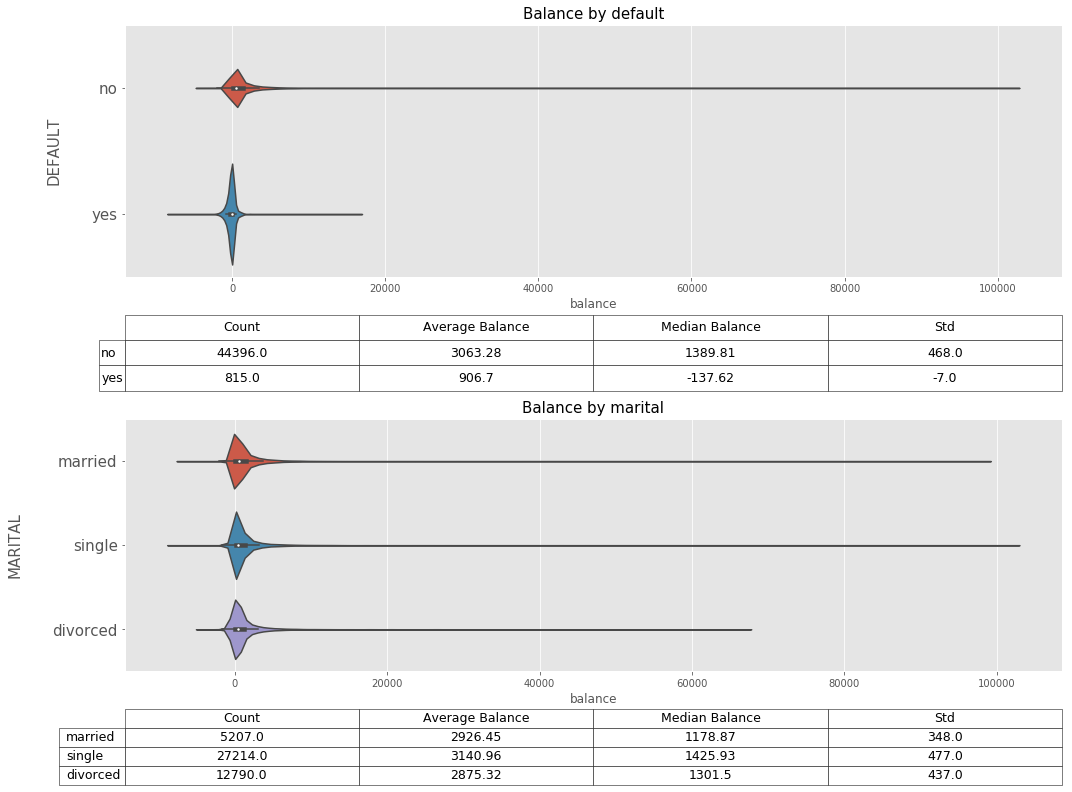

In [23]:
fig = plt.figure(figsize = (15,10))

plt.subplot(211)
balance_by_col(data, 'default')
plt.subplot(212)
balance_by_col(data, 'marital')

plt.tight_layout(h_pad = 9)

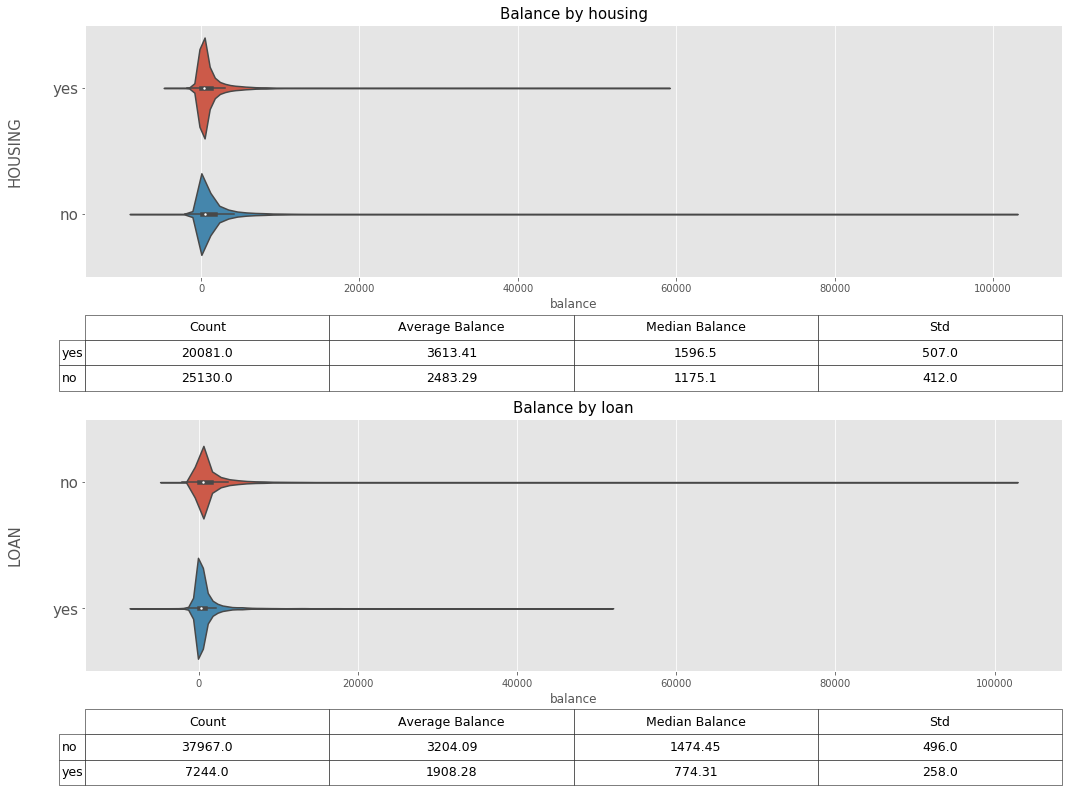

In [24]:
fig = plt.figure(figsize = (15,10))

plt.subplot(211)
balance_by_col(data, 'housing')
plt.subplot(212)
balance_by_col(data, 'loan')

plt.tight_layout(h_pad = 9)

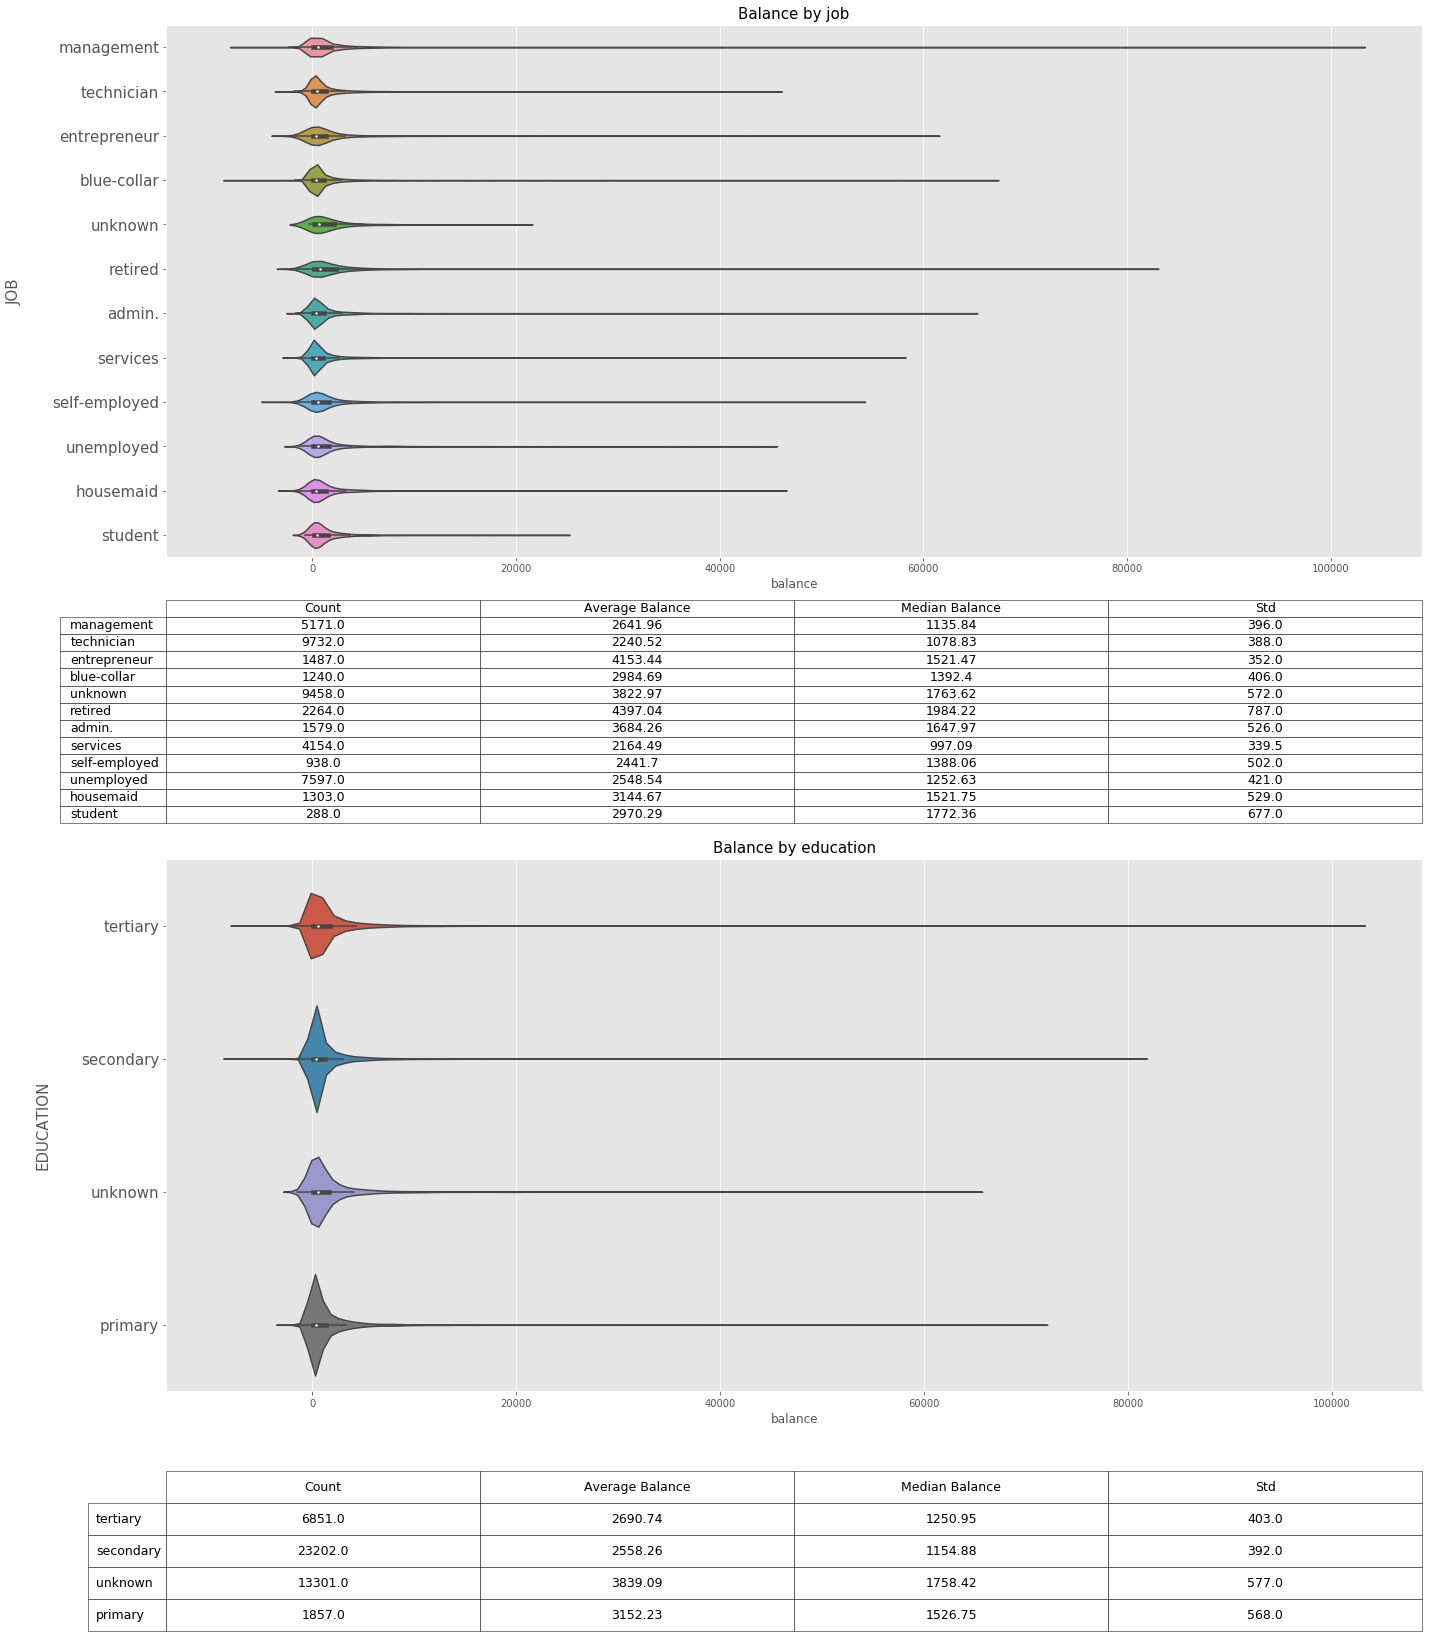

In [25]:
fig = plt.figure(figsize = (20,20))
plt.subplot(211)
balance_by_col(data, 'job')
plt.subplot(212)
balance_by_col(data, 'education')
plt.tight_layout(h_pad = 25)

In [26]:
data.pivot_table(index = ['education'], columns = ['job'], aggfunc='size')

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
education,,,,,,,,,,,,
primary,209,3758,183,627,294,795,130,345,44,158,257,51
secondary,4219,5371,542,395,1121,984,577,3457,508,5229,728,71
tertiary,572,149,686,173,7801,366,833,202,223,1968,289,39
unknown,171,454,76,45,242,119,39,150,163,242,29,127


# Subscription Rate by Categorical Variables

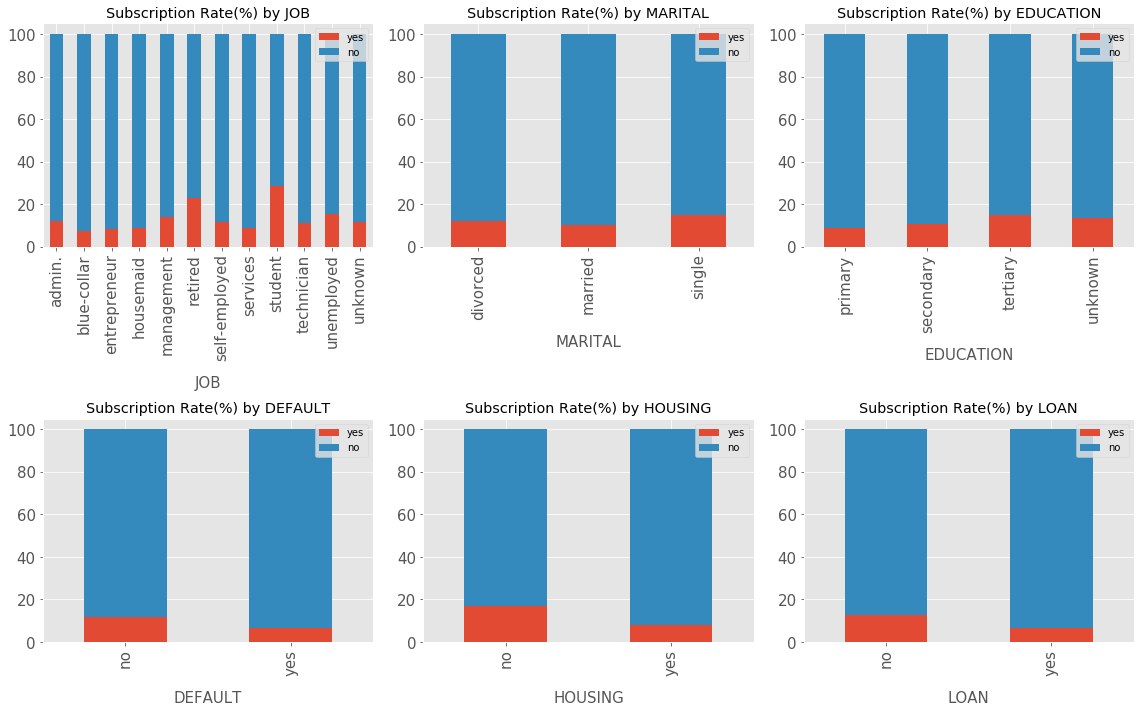

In [27]:
fig = plt.figure(figsize = (16,10))

plt.subplot(231)
subscr_rate_by_col(data, 'job')
plt.subplot(232)
subscr_rate_by_col(data, 'marital')
plt.subplot(233)
subscr_rate_by_col(data, 'education')
plt.subplot(234)
subscr_rate_by_col(data, 'default')
plt.subplot(235)
subscr_rate_by_col(data, 'housing')
plt.subplot(236)
subscr_rate_by_col(data, 'loan')

plt.tight_layout()

# Subscription Rate by Number of Contacts

# Response Rate and Marginal Response Rate by Number of Contacts

In [28]:
camp_resp = data.groupby(by = ['campaign','y']).size().unstack().fillna(0)
camp_resp['total'] = camp_resp.apply(lambda x: x.sum(), axis = 1)

sample_size = camp_resp['total'].sum()
total_resp = camp_resp['yes'].sum()

camp_resp['num_contact'] = sample_size - pd.Series([0] + camp_resp['total'].tolist()[:-1], index = camp_resp.index).cumsum()
camp_resp['resp_remain'] = total_resp - pd.Series([0] + camp_resp['yes'].tolist()[:-1], index = camp_resp.index).cumsum()

camp_resp['marg_subscr'] = round(camp_resp['yes'] / camp_resp['num_contact'], 4)
camp_resp['marg_resp'] = round(camp_resp['resp_remain'] / camp_resp['num_contact'], 4)

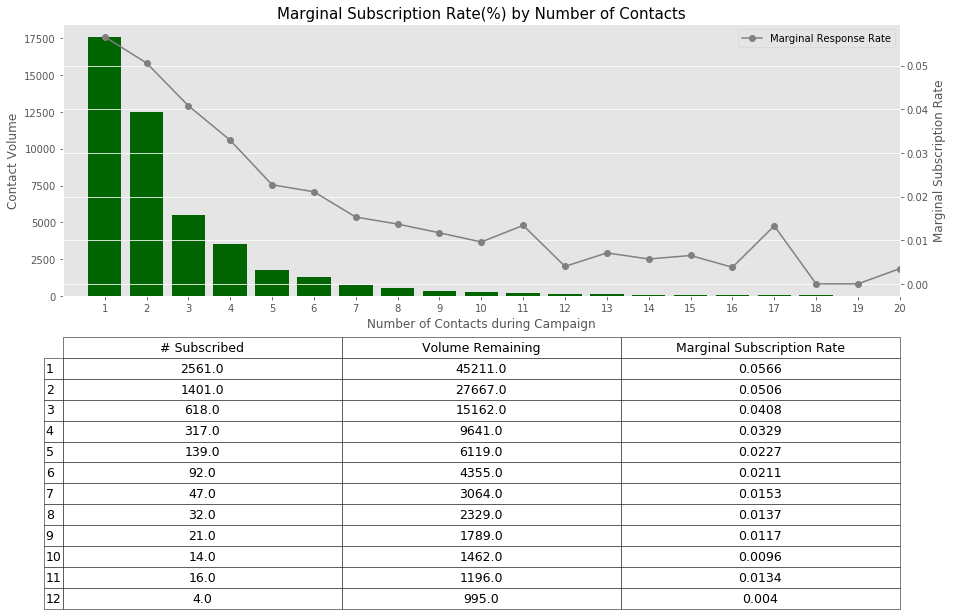

In [29]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

ax1.bar(data = camp_resp, x = camp_resp.index, height = 'total', color = 'darkgreen')
camp_resp.plot(y = 'marg_subscr', kind = 'line', marker='o', ax = ax2, 
               label = 'Marginal Response Rate', color = 'grey', lw = 1.5)

plt.title('Marginal Subscription Rate(%) by Number of Contacts', fontsize = 15)
ax2.set_ylabel('Marginal Subscription Rate')
ax1.set_ylabel('Contact Volume')

ax1.set_xlabel('Number of Contacts during Campaign')
plt.xticks(np.arange(min(camp_resp.index), max(camp_resp.index), step=1)) 
plt.xlim(0,20)

ax1.grid(b=None)

table = camp_resp[['yes','num_contact', 'marg_subscr']].head(12)
table_plot = plt.table(cellText = table.values, 
                           colLabels=['# Subscribed', 'Volume Remaining', 'Marginal Subscription Rate'], 
                           cellLoc='center',
                           rowLabels = table.head(12).index,
                           bbox=[0, -1.15, 1, 1])
table_plot.set_fontsize(12.5)

plt.show()

# Subscription Status by Previous Campaign Response

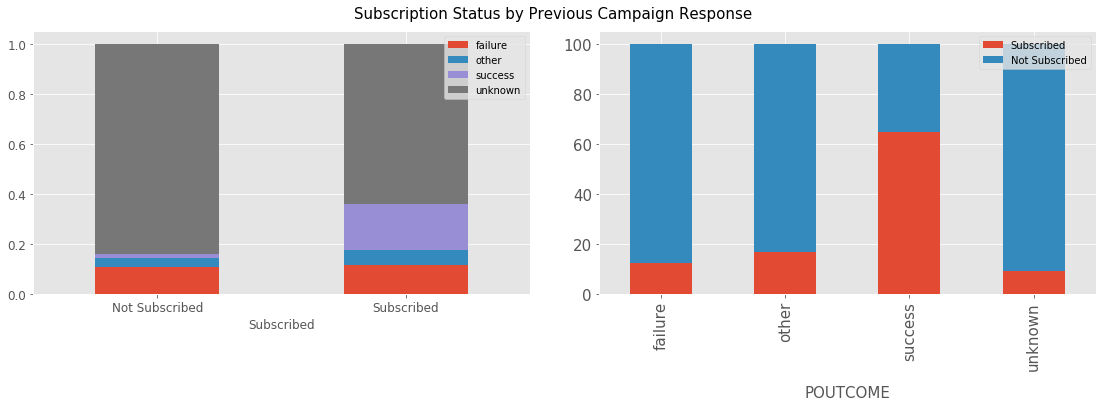

In [30]:
prev_resp = data[['poutcome','y']].groupby(by = ['poutcome','y']).size().unstack()

colnames = prev_resp.columns

prev_resp[colnames] = prev_resp[colnames].div(prev_resp.sum(axis = 0))
prev_resp = prev_resp.T

f, ax = plt.subplots(figsize = (16,6))

plt.subplot(121)
prev_plot = prev_resp.plot(kind = 'bar', stacked = True, ax = plt.gca(), fontsize = 12, rot = 360)

plt.suptitle('Subscription Status by Previous Campaign Response', fontsize = 15)
ax.set_xlabel('Subscription')

plt.subplot(122)
prev_plot2 = subscr_rate_by_col(data, 'poutcome')

prev_plot.legend(loc = 1)
prev_plot.set_xlabel('Subscribed')
prev_plot.set_xticklabels(['Not Subscribed','Subscribed'])
prev_plot2.set_title('')
prev_plot2.legend(['Subscribed','Not Subscribed'])
plt.tight_layout(pad = 3)
plt.show()

2 plots
1. poutcome response rates by number of previous contacts (line plot overlap)
2. separate plot for unknown.

In [31]:
contact_hist = data[['poutcome', 'previous','y']].groupby(by = ['poutcome', 'previous','y']).size().unstack().fillna(0).T

In [32]:
contact_hist.unknown

previous,0,1,2,5,7
y,,,,,
no,33570.0,0.0,1.0,1.0,1.0
yes,3384.0,1.0,1.0,0.0,0.0


In [33]:
contact_hist.failure

previous,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,32,35,38,51,55
y,,,,,,,,,,,,,,,,,,,,,
no,1517.0,1196.0,561.0,356.0,223.0,127.0,84.0,43.0,42.0,22.0,...,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0
yes,190.0,166.0,99.0,49.0,38.0,19.0,17.0,11.0,7.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [34]:
contact_hist.other

previous,1,2,3,4,5,6,7,8,9,10,...,25,26,27,29,30,37,40,41,58,275
y,,,,,,,,,,,,,,,,,,,,,
no,500.0,323.0,199.0,138.0,88.0,47.0,48.0,39.0,23.0,14.0,...,1.0,0.0,3.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0
yes,91.0,67.0,39.0,27.0,19.0,17.0,11.0,7.0,4.0,5.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
contact_hist.success

previous,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,21,22,28
y,,,,,,,,,,,,,,,,,,
no,172.0,130.0,88.0,49.0,26.0,20.0,18.0,8.0,3.0,5.0,5.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0
yes,301.0,222.0,156.0,95.0,64.0,47.0,26.0,21.0,13.0,15.0,7.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0
